Epoch 1/10
67/67 [==============================] - 26s 371ms/step - loss: 15.6966 - accuracy: 0.6653 - val_loss: 0.5955 - val_accuracy: 0.7794
Epoch 2/10
67/67 [==============================] - 25s 370ms/step - loss: 0.5153 - accuracy: 0.8076 - val_loss: 0.5667 - val_accuracy: 0.7439
Epoch 3/10
67/67 [==============================] - 25s 372ms/step - loss: 0.5060 - accuracy: 0.7992 - val_loss: 0.4670 - val_accuracy: 0.8299
Epoch 4/10
67/67 [==============================] - 25s 368ms/step - loss: 0.4066 - accuracy: 0.8511 - val_loss: 0.6334 - val_accuracy: 0.7888
Epoch 5/10
67/67 [==============================] - 25s 370ms/step - loss: 0.3873 - accuracy: 0.8441 - val_loss: 0.4242 - val_accuracy: 0.8336
Epoch 6/10
67/67 [==============================] - 25s 367ms/step - loss: 0.3094 - accuracy: 0.8773 - val_loss: 0.4434 - val_accuracy: 0.8355
Epoch 7/10
67/67 [==============================] - 25s 367ms/step - loss: 0.2284 - accuracy: 0.9139 - val_loss: 0.5370 - val_accuracy: 0.859

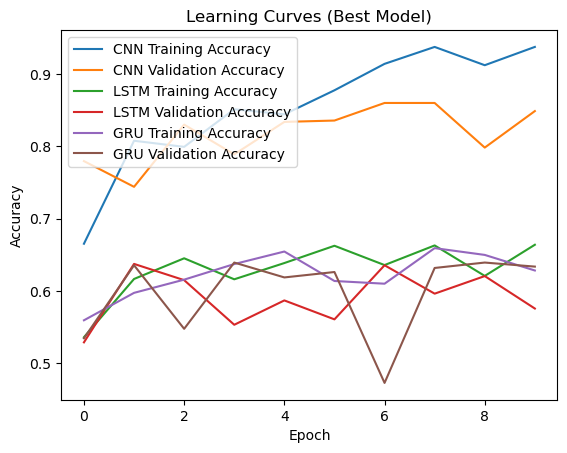

1/1 [==============================] - 0s 120ms/step
Subset of Predicted Images:


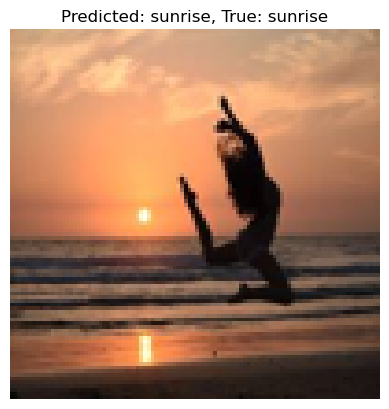

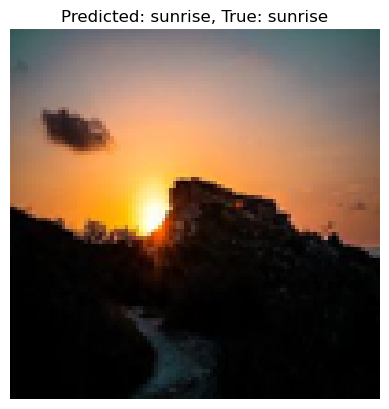

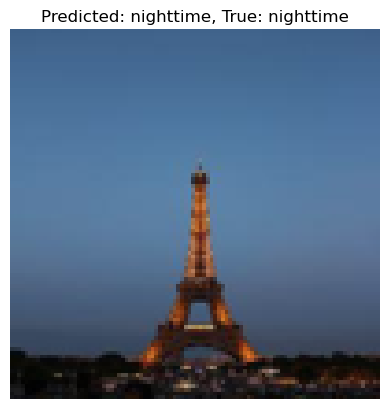

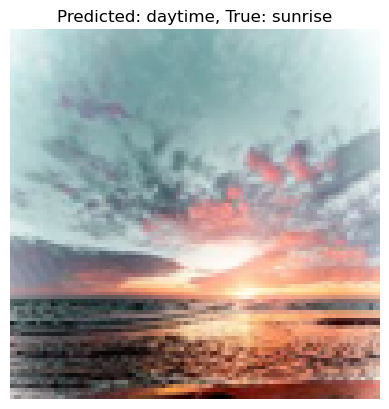

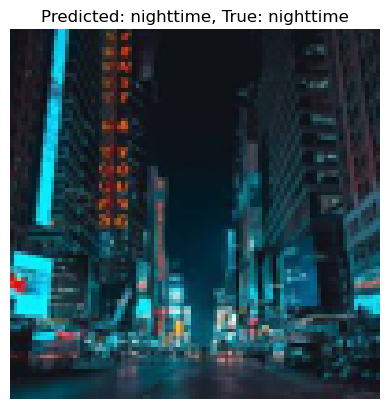

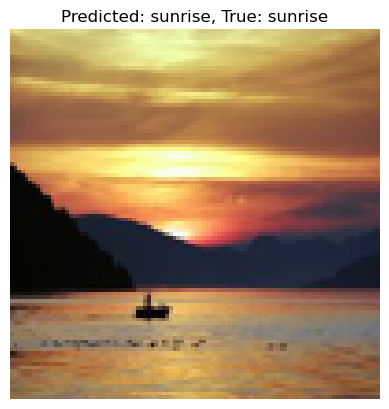

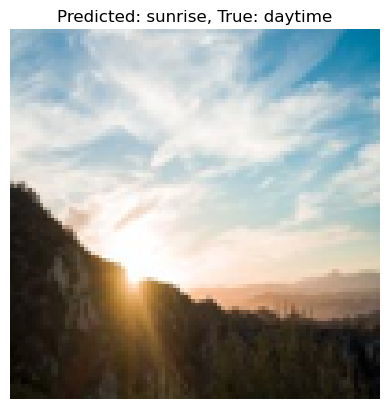

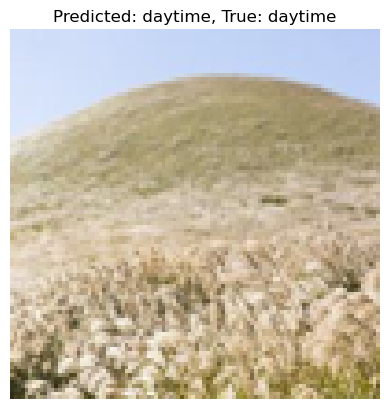

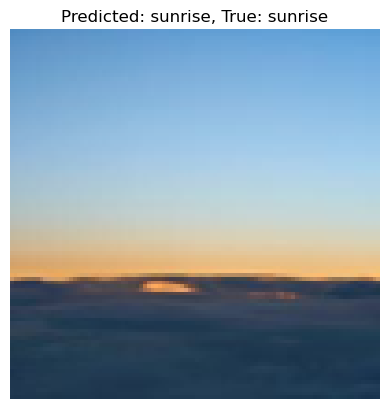

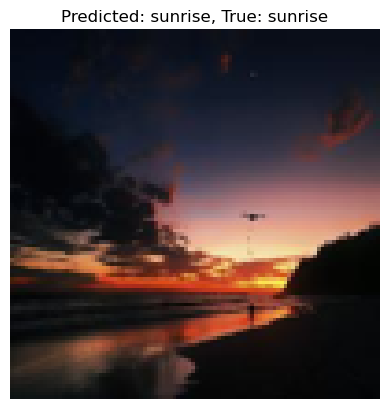

17/17 [==============================] - 2s 89ms/step


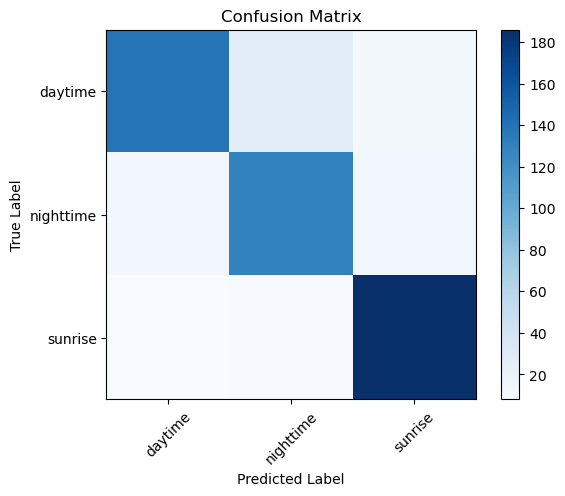

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, GRU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the path to your image dataset directory
dataset_directory = '/kaggle/input/timeofdaydataset'

# Function to load and preprocess the images
def load_images(directory):
    X = []
    y = []
    for category in os.listdir(directory):
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            for filename in os.listdir(category_dir):
                if filename.endswith('.jpeg') or filename.endswith('.png'):
                    image_path = os.path.join(category_dir, filename)
                    image = Image.open(image_path)
                    image = image.resize((100, 100))
                    image = np.array(image)
                    X.append(image)
                    y.append(category)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess the images
X, y = load_images(dataset_directory)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Create a CNN model
inputs = Input(shape=(100, 100, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
cnn_outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

cnn_model = Model(inputs=inputs, outputs=cnn_outputs)
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data for LSTM and GRU models
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3]))

# Create an LSTM model
inputs_lstm = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
x_lstm = LSTM(128)(inputs_lstm)
x_lstm = Dense(256, activation='relu')(x_lstm)
lstm_outputs = Dense(len(label_encoder.classes_), activation='softmax')(x_lstm)

lstm_model = Model(inputs=inputs_lstm, outputs=lstm_outputs)
lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a GRU model
inputs_gru = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
x_gru = GRU(128)(inputs_gru)
x_gru = Dense(256, activation='relu')(x_gru)
gru_outputs = Dense(len(label_encoder.classes_), activation='softmax')(x_gru)

gru_model = Model(inputs=inputs_gru, outputs=gru_outputs)
gru_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train_lstm, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test_lstm, y_test)
)

# Train the GRU model
gru_history = gru_model.fit(
    X_train_lstm, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test_lstm, y_test)
)

# Compare the accuracies of the CNN, LSTM, and GRU models
cnn_accuracy = cnn_history.history['val_accuracy'][-1]
lstm_accuracy = lstm_history.history['val_accuracy'][-1]
gru_accuracy = gru_history.history['val_accuracy'][-1]

print("CNN Accuracy:", cnn_accuracy)
print("LSTM Accuracy:", lstm_accuracy)
print("GRU Accuracy:", gru_accuracy)

# Determine the model with the highest accuracy
best_model = cnn_model
best_accuracy = cnn_accuracy

if lstm_accuracy > best_accuracy:
    best_model = lstm_model
    best_accuracy = lstm_accuracy

if gru_accuracy > best_accuracy:
    best_model = gru_model
    best_accuracy = gru_accuracy

# Plot the learning curves for the best model
plt.figure()
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')
plt.title("Learning Curves (Best Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Print a subset of predicted images by the best model
subset_indices = np.random.choice(len(X_test), size=10, replace=False)
subset_images = X_test[subset_indices]
subset_labels = y_test[subset_indices]

subset_predictions = best_model.predict(subset_images)
subset_predicted_labels = np.argmax(subset_predictions, axis=1)
subset_predicted_labels = label_encoder.inverse_transform(subset_predicted_labels)

subset_true_labels = label_encoder.inverse_transform(subset_labels)

print("Subset of Predicted Images:")
for i in range(len(subset_images)):
    plt.figure()
    plt.imshow(subset_images[i])
    plt.title(f"Predicted: {subset_predicted_labels[i]}, True: {subset_true_labels[i]}")
    plt.axis('off')
    plt.show()

# Compute and display the confusion matrix for the best model
y_pred = np.argmax(best_model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
